In [ ]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import tqdm.notebook as tqdm
from google.colab import drive
import math

#########################################################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet import ResNet50

from keras.applications.imagenet_utils import decode_predictions

import matplotlib.pyplot as plt
import matplotlib.image as mpimg



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
drive.mount('/content/drive',force_remount=True)

In [ ]:
test_size = 0.2
val_size = 0.1

batch_size = 20
num_classes = 3
learning_rate = 0.0005
num_epochs = 10

# **Leer data**

In [ ]:
dataset_dir = "./drive/MyDrive/Data"
trans = transforms.Compose([transforms.Resize([255,255]), transforms.ToTensor()])

dataset = datasets.ImageFolder(dataset_dir, transform = trans)
n_test = int(np.floor(test_size * len(dataset)))
n_val = int(np.floor(val_size * len(dataset)))
n_train = len(dataset) - n_test - n_val

In [ ]:
train_set, test_set, val_set = torch.utils.data.random_split(dataset,[n_train, n_test, n_val])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set , batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set , batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
print("Tamaño dataset: ",len(dataset))
print("Tamaño train set: ",len(train_set))
print("Tamaño test set: ",len(test_set))
print("Tamaño val set: ",len(val_set))

print("Tamaño batch train: ",len(train_loader))
print("Tamaño batch test: ",len(test_loader))
print("Tamaño batch val: ",len(val_loader))

print("Clases detectadas: ", dataset.class_to_idx)

c = dataset.targets.count(0)
f = dataset.targets.count(1)
plt.pie([c, f] , labels = dataset.classes, autopct = '%1.1f%%', startangle = 90)
plt.show() 

# **Función para mostrar imágenes**

In [ ]:
def Show_imgs(imgs, name,  size = 3, color = True):
  color_m ='jet'
  if color == False:
    color_m ='gray'
  print('******************' + name  +  '**************************')
  img_numbers = imgs.shape[0]
  rows = cols = math.ceil(np.sqrt(img_numbers))
  
  fig = plt.figure(figsize=(rows*size, cols*size))
  for i in range(0, rows*cols):
    fig.add_subplot(rows, cols,i+1)
    if i<img_numbers:
      plt.imshow(imgs[i].detach(), cmap = 'gray')
  plt.show()

# **Error**

In [ ]:
def plot_error(list_loss, val_loss):
  fig, ax = plt.subplots()
  ax.plot(list_loss, 'y', label = 'train loss')
  ax.plot(val_loss, 'b', label = 'test loss')
  plt.title("Error vs Epoch Batch")
  plt.xlabel("Epoch")
  plt.ylabel("Error")
  ax.legend()

# **Accuracy**

In [ ]:
def plot_accuracy(cc,tt):
  ttt = []
  for i in range(0,len(cc)):
    ttt.append(100 * cc[i] / tt[i])

  fig, ax = plt.subplots()
  ax.plot(ttt, 'g', label = 'Testing Accuracy')
  plt.title("Accuracy vs Batch - Batch")
  plt.xlabel("Batch")
  plt.ylabel("Accuracy")
  ax.legend()

# **Validación**

In [ ]:
def validation(model,loss_fn):
  current_val_loss = 0
  with torch.no_grad():
    for images, labels in tqdm.tqdm(val_loader, desc="Validating", leave=False):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = loss_fn(outputs, labels)
      current_val_loss += loss.item()
  return current_val_loss / len(val_loader)

# **Train**

In [ ]:
def train(model, optimizer, loss_fn, num_epochs, early_stop,validation_loader,earlystop):
  total_step = len(train_loader)
  list_loss = []
  val_loss = []
  ul_val_loss = 1000
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    current_loss = 0
    for i, (images, labels) in enumerate(tqdm.tqdm(train_loader, desc="Training", leave=False)):
      images = images.to(device)
      labels = labels.to(device)
      output = model(images)
      loss = loss_fn(output, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      current_loss += loss.item()
              
      if (i+1) % 117 == 0:
        print ('Step [{}/{}], Loss: {:.4f}'.format(i+1, total_step, loss.item()))

    list_loss.append(current_loss/total_step)
    val_loss.append(validation(model,loss_fn))
    #if earlystop is True:
    #    ul_val_loss = EarlyStopping(model,current_val_loss,ul_val_loss)

  print('Finished Training Trainset')
  return list_loss, val_loss

# **Testing**

In [ ]:
def testing(model):
  cc = []
  tt = []
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm.tqdm(test_loader, desc="Testing", leave=False):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images) 
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      tt.append(total)
      correct += (predicted == labels).sum().item()
      cc.append(correct)
    print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_set), 100 * correct / total))
  return cc, tt

# **Early Stopping**

In [ ]:
contador=0
def EarlyStopping(modelo, current_val_loss, ul_val_loss):
    global contador
    patience = 10
    #print('The current loss:', current_val_loss)
    #print('Last val loss:', ul_val_loss)
    if current_val_loss > ul_val_loss:
        contador = contador + 1
        print('Contador:', contador)
        if contador >= patience:
            return modelo
    else:
        print('Contador: 0')
        trigger_times = 0
    return current_val_loss

# **Ejemplo de la CNN para una iteración**

******************First Image**************************


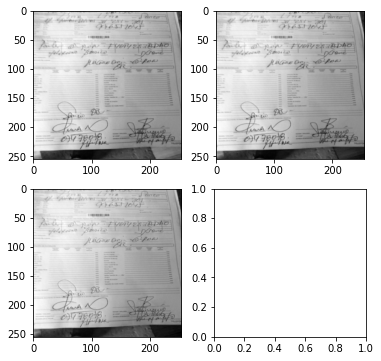

******************layer 1**************************


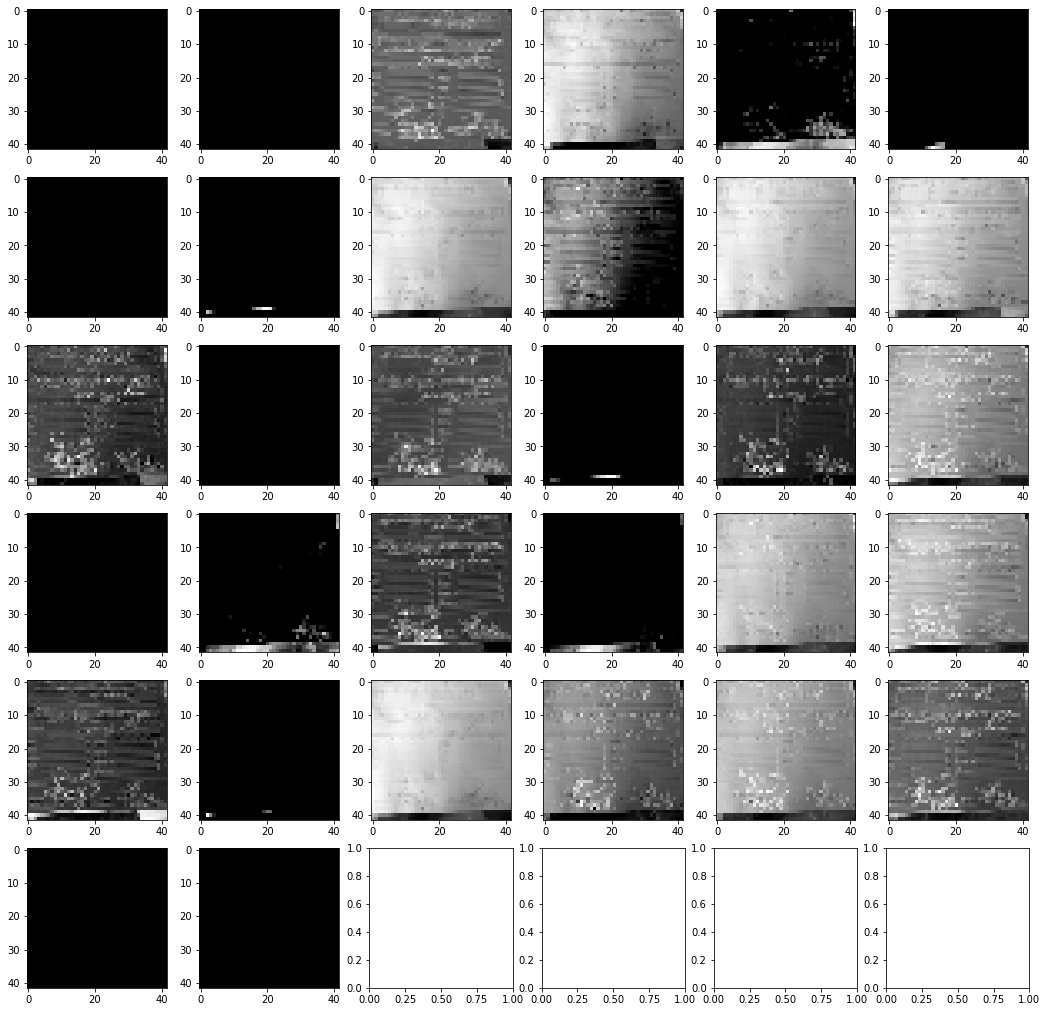

torch.Size([1, 32, 42, 42])
******************layer 2**************************


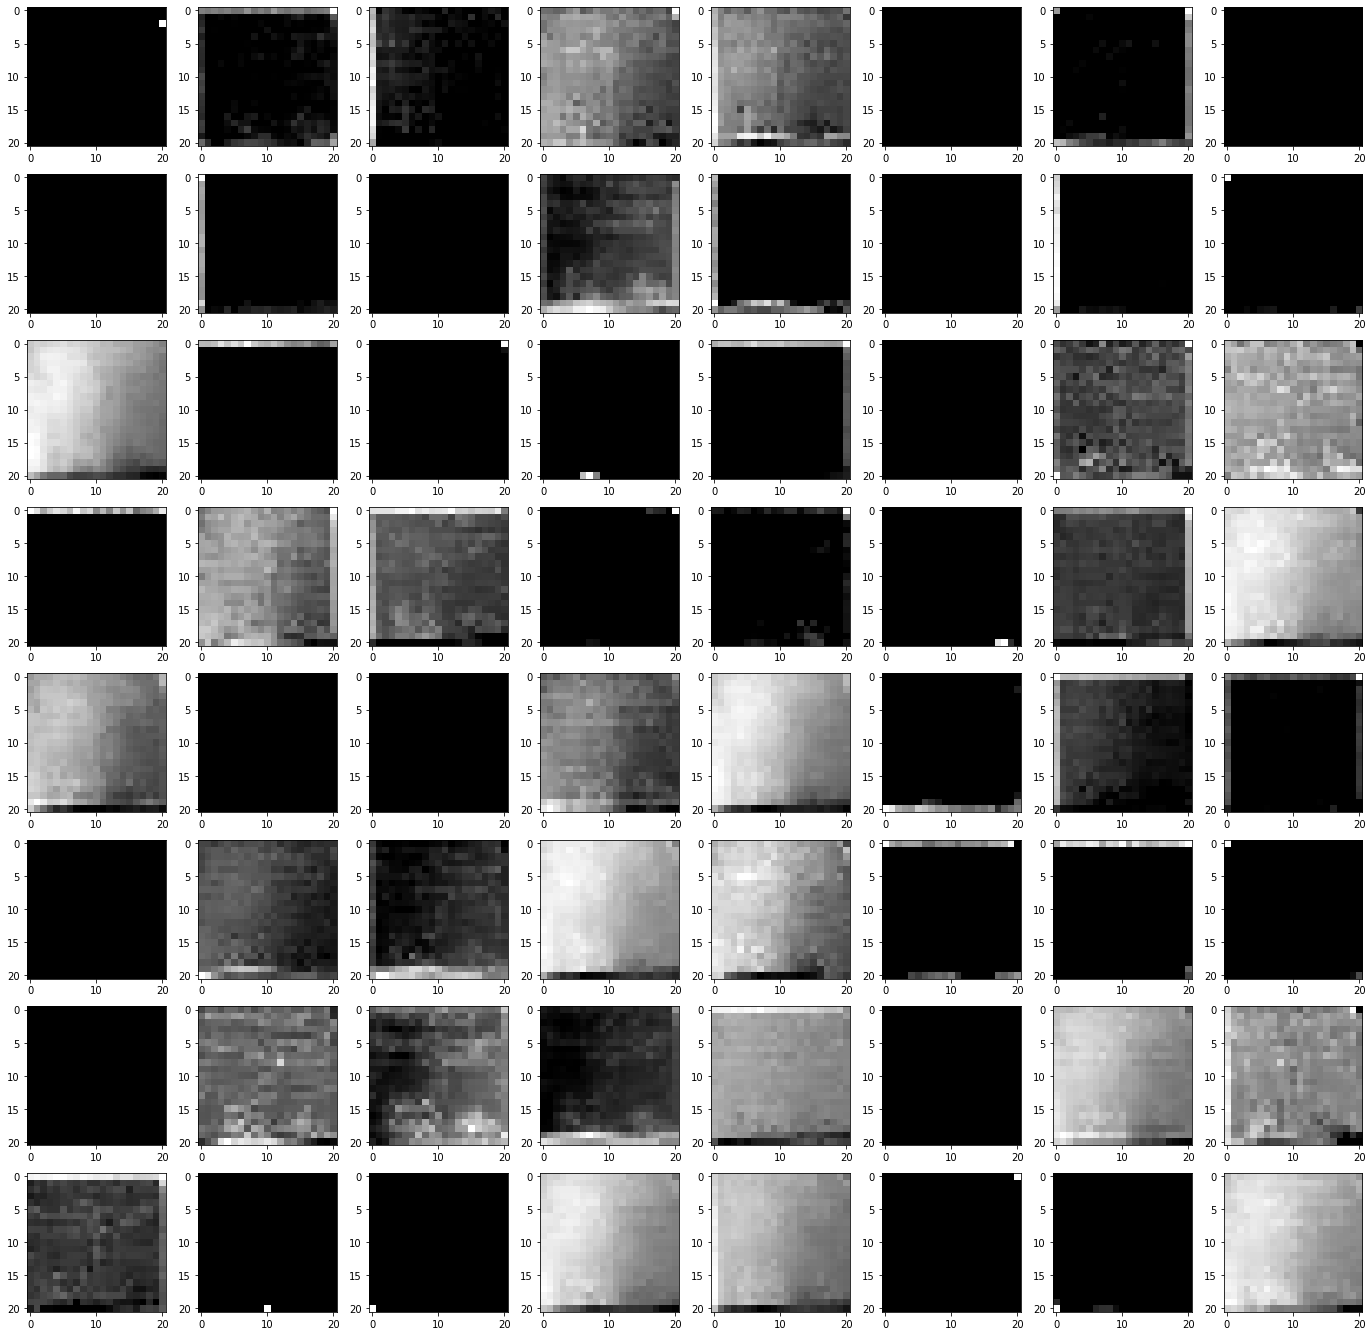

torch.Size([1, 64, 21, 21])


In [ ]:
img, label = train_set[100]
img = img.unsqueeze(0)
#[batch_size, Channel, H,W]

Show_imgs(img[0], "First Image")

layer1 = nn.Sequential(nn.Conv2d(3,32,3,3,0), nn.ReLU(), nn.MaxPool2d(2,2))
layer2 = nn.Sequential(nn.Conv2d(64,8,3,1,1), nn.ReLU(), nn.MaxPool2d(2,2))

out = layer1(img)
Show_imgs(out[0], "layer 1")
print(out.shape)

out2 = layer2(out)
Show_imgs(out2[0], "layer 2")
print(out2.shape)


# **CNN Inicial sin cambiar hyperparametros**

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3,32,3,3,0), nn.ReLU(), nn.MaxPool2d(2,2))
        self.layer2 = nn.Sequential(nn.Conv2d(32,64,3,1,1), nn.ReLU(), nn.MaxPool2d(2,2))
        self.fc = nn.Linear(21*21*64, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
model         = CNN(num_classes).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)
print([ e.shape  for e in model.fc.parameters()])
model.fc.weight

In [ ]:
list_loss1, val_loss1 = train(model, optimizer, loss_fn, num_epochs,train_loader,val_loader,True)

In [ ]:
cc1, tt1 = testing(model)

In [ ]:
plot_error(list_loss1,val_loss1)

In [ ]:
plot_accuracy(cc1,tt1)

# **Nuestro CNN**

In [ ]:
batch_size = 32
num_classes = 3
learning_rate = 0.001
num_epochs = 15

In [ ]:
train_set, test_set, val_set = torch.utils.data.random_split(dataset,[n_train, n_test, n_val])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set , batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set , batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
class CNN_P(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN_P, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3,4,3,1,2), nn.BatchNorm2d(4),nn.Dropout(), nn.ReLU(), nn.MaxPool2d(2,2))
        self.layer2 = nn.Sequential(nn.Conv2d(4,8,6,1,2), nn.BatchNorm2d(8),nn.Dropout(),nn.ReLU(), nn.MaxPool2d(2,4))
        self.layer3 = nn.Sequential(nn.Conv2d(8,16,9,1,2), nn.BatchNorm2d(16),nn.Dropout(), nn.ReLU(), nn.MaxPool2d(3,2))
        self.layer4 = nn.Sequential(nn.Conv2d(16,32,7,1,2), nn.BatchNorm2d(32),nn.Dropout(),nn.ReLU(), nn.MaxPool2d(2,2))
        self.fc = nn.Linear(5*5*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
model2         = CNN_P(num_classes).to(device)
loss_fn2       = nn.CrossEntropyLoss()
optimizer2     = torch.optim.Adam(model2.parameters(), lr = learning_rate)
print([ e.shape  for e in model2.fc.parameters()])
model2.fc.weight

In [ ]:
list_loss2, val_loss2 = train(model2, optimizer2, loss_fn2, num_epochs,train_loader,val_loader,True)

In [ ]:
cc2, tt2 = testing(model2)

In [ ]:
plot_error(list_loss2, val_loss2)

In [ ]:
plot_accuracy(cc2,tt2)

# **Usando modelos pre-entrenados**

In [ ]:
epochs= 50
num_classes = 2
batch_size = 32
mid_filters = 90
path = "/content/drive/MyDrive/Data"

In [ ]:

data_gen  = ImageDataGenerator(
    zoom_range=[0.5,1.5],
    shear_range=15,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2 #Usar 20% para pruebas
    )

training_set = data_gen.flow_from_directory(
    path,
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    subset='training',
    class_mode = 'categorical'
)

testing_set = data_gen.flow_from_directory(
    path,
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    subset='validation',
    class_mode = 'categorical'
)



In [ ]:
training_set.class_indices

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
mobilenetv2 = hub.KerasLayer(url,input_shape=(224,224,3))


In [ ]:
#Congelar el modelo descargado
mobilenetv2.trainable = False

In [ ]:
from keras.layers.convolutional.conv2d import Convolution2D
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(2,activation='softmax')
])



In [ ]:
modelo.summary()

In [ ]:
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
historial = modelo.fit(
    training_set, epochs=epochs, batch_size=32,
    validation_data=testing_set
)

In [ ]:
#Graficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

Se intento usar otros modelos para luego comparar cual es el mejor, pero por temas de tiempo nose pudo.

### *ResNet*

In [ ]:
base_model = ResNet50(
    weights='imagenet',
    input_shape=(250, 250, 3),
    include_top=False)

print(base_model.summary())

# **VGG16**

In [ ]:
base_model = VGG16(
    weights='imagenet',
    input_shape=(225, 225, 3),
    include_top=False)

print(base_model.summary())

In [ ]:
base_model.trainable = False

In [ ]:
def get_newmodel(base_model,num_classes):

    inputs = keras.Input(shape=(height, width, 3))
    
    x = base_model(inputs, training=False)

    x = Sequential()(x)
    
    x = Conv2D(filters=32,kernel_size=(3,3),padding="same",activation='relu',input_shape=(250,250,3))(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(rate=0.5)(x)
    
    x = Conv2D(filters=64,kernel_size=(3,3),padding="same",activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(rate=0.5)(x)
    
    x = Flatten()(x)
    x = Dense(150,activation='relu')(x)

    outputs = Dense(num_classes,activation="softmax")(x)
    
    model = keras.Model(inputs, outputs)
    model.summary()
    return model

In [ ]:
base_model.trainable = True
set_trainable = False

for layer in base_model.layers:
  if layer.name == 'conv2_block1_1_conv':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False


print(base_model.summary())

In [ ]:
model = get_newmodel(base_model,2)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1 = model.fit(training_set, epochs=epochs, validation_data=testing_set, verbose=1,validation_steps=10,steps_per_epoch=15)

In [ ]:
def show_plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
    plt.show()

show_plot(history)